In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [84]:
def stationarity_check(df):
    
    def adf_check(series):
    
        results = adfuller(series, autolag='AIC')
        print()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Augmented Dickey-Fuller Unit Root Test:")
        labels = [
            "ADF Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ]
        
        for value, label in zip(results, labels):
            print(f"{label} : {value}")
            
        if results[1] <= 0.05:
            print("Reject the null hypothesis: Series is stationary and has no unit root")
        else:
            print("Weak evidence against the null hypothesis: Series is non-stationary and has a unit root")
            
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        
    
    adf_check(df['mean'])
    
    df["Temp. First Difference"] = df["mean"] - df["mean"].shift(1)
    df["Seasonal Difference"] = df["mean"] - df["mean"].shift(365)
    df["Seasonal First Difference"] = df["Temp. First Difference"] - df[
        "Temp. First Difference"
    ].shift(365)
    adf_check(df["Seasonal First Difference"].dropna())

    return df

def acf_pacf(df, lags=150):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plot_acf(df["mean"], lags=lags, ax=ax[0])
    plot_pacf(df["mean"], lags=lags, ax=ax[1])
    plt.show()
    
def SARIMAX(df, period = 365):
    model = sm.tsa.arima.ARIMA(
        df["mean"],
        order=(3, 0, 0),
        seasonal_order=(0, 1, 0, period)
    )
    
    results = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
    print(results.summary())
    
    return results

def residual_plot(results):
    resid_plots1 = plt.figure(figsize=(12, 6))
    plt.plot(results.resid)
    plt.title("Residuals", figure=resid_plots1)
    plt.xlabel("Date", figure=resid_plots1)
    plt.ylabel("Residuals", figure=resid_plots1)
    plt.show()
    
    resid_plots2 = plt.figure(figsize=(12, 6))
    ax = resid_plots2.add_subplot(111)
    plt.title("Residuals Kernel Denisity Function", figure=resid_plots2)
    plt.xlabel("Date", figure=resid_plots2)
    results.resid.plot(kind='kde', ax=ax)

def model_validation(df, results, forecast_length=365):
    df["forecast"] = results.predict(start=df.index[-forecast_length], end=df.index[-1], dynamic=False)
    
    forecast_test_data_plot = plt.figure(figsize=(12, 6))
    ax = forecast_test_data_plot.add_subplot(111)
    ax.set_title('Forecast of Temperature')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Temperature (C)')
    ax.plot(df.index[-forecast_length * 5:-forecast_length], df["mean"][-forecast_length * 5:-forecast_length], label="Observed")
    ax.plot(df.index, df["Forecast"], label="Forecast")
    ax.legend()
    plt.show()
    

def forecast(df, results, forecast_length, plot_length=365*5):
    future_dates = pd.date_range(start=df.index[-1] + dt.timedelta(days=1), periods=forecast_length, freq='D')
    future_df = pd.DataFrame(index=future_dates, columns=df.columns)
    
    future_df["forecast"] = results.predict(start=future_dates[0], end=future_dates[-1], dynamic= False)
    
    
    forecast_test_data_plot = plt.figure(figsize=(12, 6))
    ax = forecast_test_data_plot.add_subplot(111)
    plt.title(f'Forecast of Temperature for the next {forecast_length} days', figure=forecast_test_data_plot)
    plt.xlabel('Date', figure=forecast_test_data_plot)
    plt.ylabel('Mean Temperature (C)', figure=forecast_test_data_plot)
    future_df["forecast"].plot(ax=ax, label='Forecast')
    df['mean'][-plot_length:].plot(ax=ax, label='Observed')
    plt.show()
    
    return future_df
    

In [85]:
train_data = pd.read_csv('Data/train_data.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)
train_data = train_data.resample('D').asfreq().fillna(method='ffill')

In [86]:
df = stationarity_check(train_data)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -14.667714523300521
p-value : 3.304124929163402e-27
#Lags Used : 52
Number of Observations Used : 33275
Reject the null hypothesis: Series is stationary and has no unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -42.459222195959626
p-value : 0.0
#Lags Used : 51
Number of Observations Used : 32910
Reject the null hypothesis: Series is stationary and has no unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


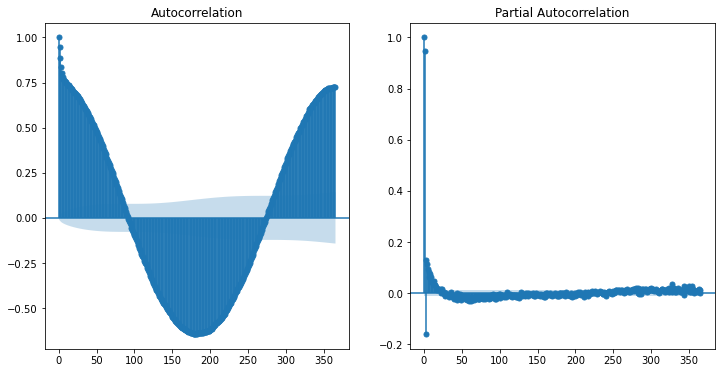

In [82]:
acf_pacf(train_data, lags= 365)

In [75]:
results = SARIMAX(train_data, period=365)

/Users/gianiranzetti/anaconda3/envs/ClassMacroeconometrics/lib/python3.6/site-packages/statsmodels/tsa/arima/model.py:376: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  ' estimation by method "%s".' % method)


                                     SARIMAX Results                                     
Dep. Variable:                              mean   No. Observations:                33328
Model:             ARIMA(3, 0, 0)x(0, 1, 0, 365)   Log Likelihood              -77670.034
Date:                           Mon, 07 Apr 2025   AIC                         155348.067
Time:                                   14:53:06   BIC                         155381.680
Sample:                               01-01-1933   HQIC                        155358.804
                                    - 03-31-2024                                         
Covariance Type:                    Not computed                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0164        nan        nan        nan         nan         nan
ar.L2         -0.2806        nan        nan

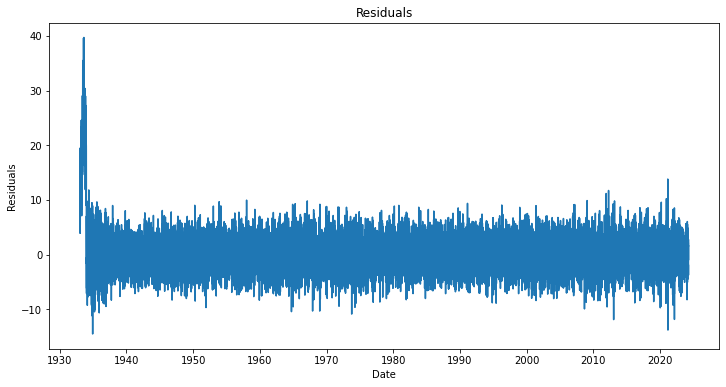

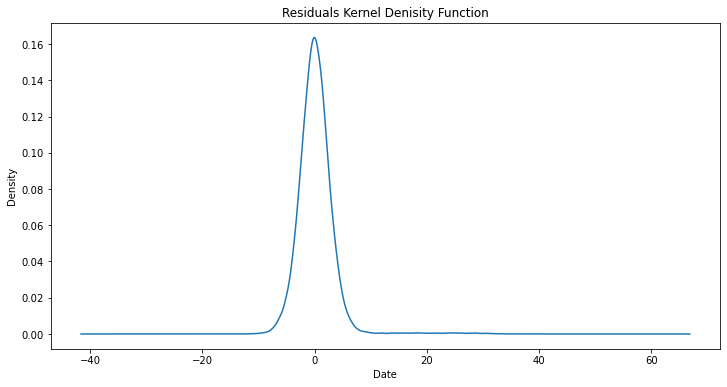

In [76]:
residual_plot(results)

In [77]:
test_data = pd.read_csv('Data/test_data.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)
test_data = test_data.resample('D').asfreq().fillna(method='ffill')

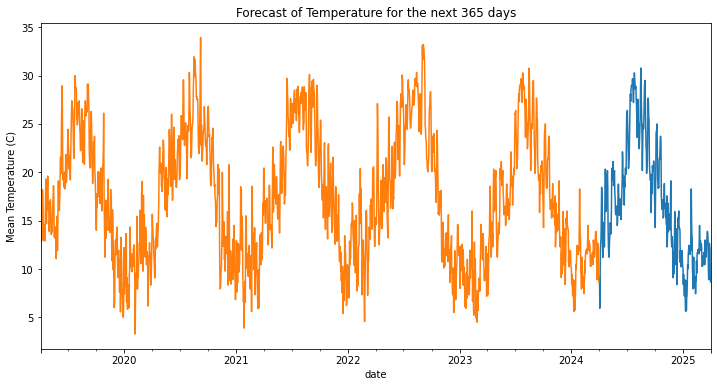

In [78]:
forecast_df = forecast(train_data, results, forecast_length=365)

In [79]:
forecast_df['2024-01-01':]

,mean,max,min,Temp. First Difference,Seasonal Difference,Seasonal First Difference,forecast
2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,8.758040
2024-04-02,NaN,NaN,NaN,NaN,NaN,NaN,9.114758
2024-04-03,NaN,NaN,NaN,NaN,NaN,NaN,5.940853
2024-04-04,NaN,NaN,NaN,NaN,NaN,NaN,8.637388
2024-04-05,NaN,NaN,NaN,NaN,NaN,NaN,12.107962
...,...,...,...,...,...,...,...
2025-03-27,NaN,NaN,NaN,NaN,NaN,NaN,12.670000
2025-03-28,NaN,NaN,NaN,NaN,NaN,NaN,12.330000
2025-03-29,NaN,NaN,NaN,NaN,NaN,NaN,12.110000
2025-03-30,NaN,NaN,NaN,NaN,NaN,NaN,9.170000


In [80]:
forecast_df = forecast_df[['mean', 'forecast']]

#Start forecast df where the 'forecast' column begins
forecast_df = forecast_df[forecast_df['forecast'].notna()]
forecast_df['mean'] = test_data['mean']

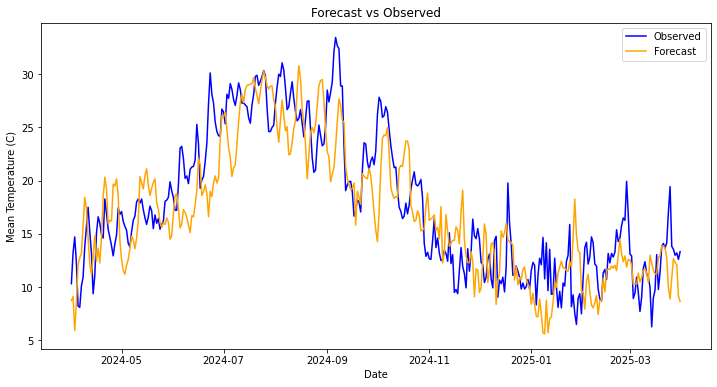

In [81]:
# plot both series inside forecast_df

plt.figure(figsize= (12, 6))
plt.plot(forecast_df.index, forecast_df['mean'], label='Observed', color='blue')
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='orange')
plt.title('Forecast vs Observed')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (C)')
plt.legend()
plt.show()